In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [ ]:
file = '/Users/james/Desktop/gaia_tmp/gaia_dr1tgas_dr2_xmatch.csv'
df = pd.read_csv(file)

In [4]:
print(df.columns)

Index([u'angDist', u'ra_ep2000', u'dec_ep2000', u'errHalfMaj', u'errHalfMin',
       u'errPosAng', u'ra', u'dec', u'hip', u'tycho2_id', u'solution_id',
       u'source_id', u'random_index', u'ref_epoch', u'ra_error', u'dec_error',
       u'parallax', u'parallax_error', u'pmra', u'pmra_error', u'pmdec',
       u'pmdec_error', u'ra_dec_corr', u'ra_parallax_corr', u'ra_pmra_corr',
       u'ra_pmdec_corr', u'dec_parallax_corr', u'dec_pmra_corr',
       u'dec_pmdec_corr', u'parallax_pmra_corr', u'parallax_pmdec_corr',
       u'pmra_pmdec_corr', u'astrometric_n_obs_al', u'astrometric_n_obs_ac',
       u'astrometric_n_good_obs_al', u'astrometric_n_good_obs_ac',
       u'astrometric_n_bad_obs_al', u'astrometric_n_bad_obs_ac',
       u'astrometric_delta_q', u'astrometric_excess_noise',
       u'astrometric_excess_noise_sig', u'astrometric_primary_flag',
       u'astrometric_relegation_factor', u'astrometric_weight_al',
       u'astrometric_weight_ac', u'astrometric_priors_used',
       u'matche

In [8]:
df.shape

(2614139, 99)

Need to pick out "ok" sources, good S/N, good xmatch (since CDS did 5" match...)

(519136,)


Text(0,0.5,'# Sources')

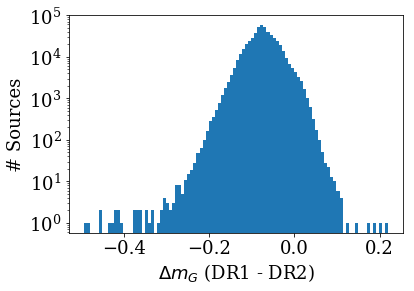

In [48]:
ok = np.where((np.abs(df[u'phot_g_mean_flux_error'] / df[u'phot_g_mean_flux']) < 0.01) & 
              (df[u'phot_g_mean_flux_error'] > 0) & 
              (df[u'angDist'] < 0.1) & 
              np.isfinite(df[u'bp_rp']) & 
              np.isfinite(df[u'phot_g_mean_mag']) &
              (df[u'source_id'] == df[u'source_id.1']))

print(ok[0].shape)

DeltaG = df[u'phot_g_mean_mag'].values[ok] - df[u'phot_g_mean_mag.1'].values[ok]

_ = plt.hist(DeltaG, bins=100)
plt.xlabel(r'$\Delta m_G$ (DR1 - DR2)')
plt.yscale('log')
plt.ylabel('# Sources')

(0, 0.01)

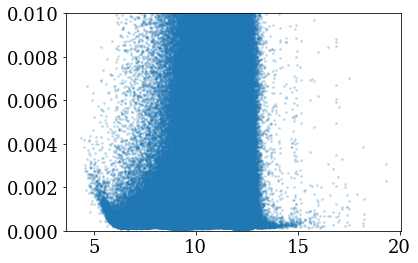

In [105]:
plt.scatter(np.abs(df[u'phot_g_mean_mag'].values), 
                   np.abs(df[u'phot_g_mean_flux_error.1'].values / df[u'phot_g_mean_flux.1'].values), 
            s=3, alpha=0.2)
plt.ylim(0,0.01)

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


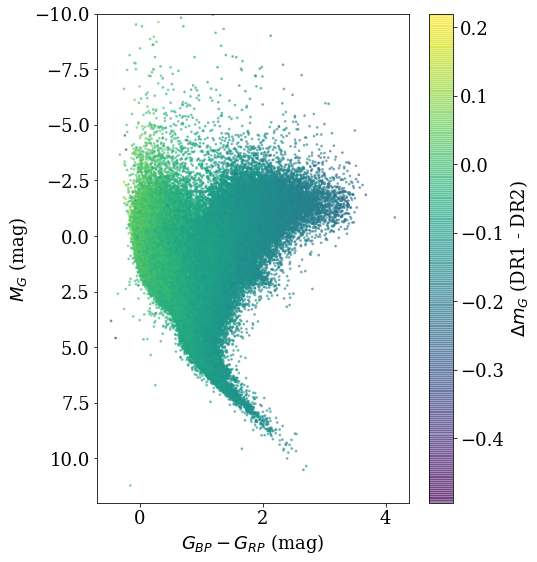

In [49]:

plt.figure(figsize=(7,9))
plt.scatter(df[u'bp_rp'].values[ok], 
            df[u'phot_g_mean_mag.1'].values[ok] - 5. * np.log10(1000./df[u'parallax.1'].values[ok])  + 5, 
            s=3, alpha=0.5, c=DeltaG)
plt.ylim(12,-10);
plt.xlabel('$G_{BP} - G_{RP}$ (mag)');
plt.ylabel('$M_G$ (mag)');
cb = plt.colorbar()
cb.set_label(r'$\Delta m_G$ (DR1 - DR2)')


A strong color term in this plot.... looks like we're rediscovering the DR2 pipeline!

So.... let's fit a line and move on! Maybe that'll do the trick?

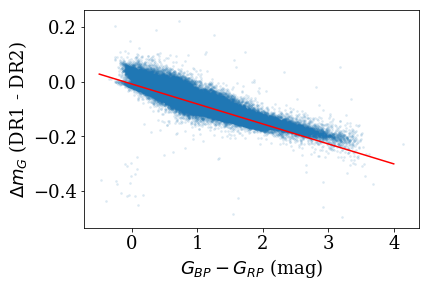

In [54]:
fit = np.polyfit(df[u'bp_rp'].values[ok], DeltaG, 1, )

plt.scatter(df[u'bp_rp'].values[ok], DeltaG, s=3, alpha=0.1)
plt.plot([-0.5, 4], np.polyval(fit, [-0.5, 4]), c='r')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)');
plt.ylabel(r'$\Delta m_G$ (DR1 - DR2)');

Text(0,0.5,'# Sources')

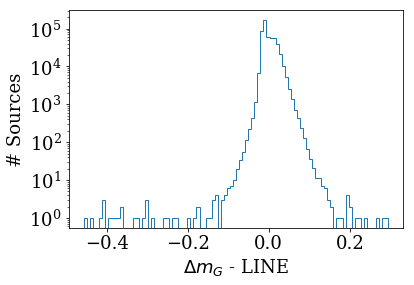

In [60]:
_ = plt.hist(DeltaG - LINE, histtype='step', bins=100)
plt.yscale('log')
plt.xlabel(r'$\Delta m_G$ - LINE')
plt.ylabel('# Sources')

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log10


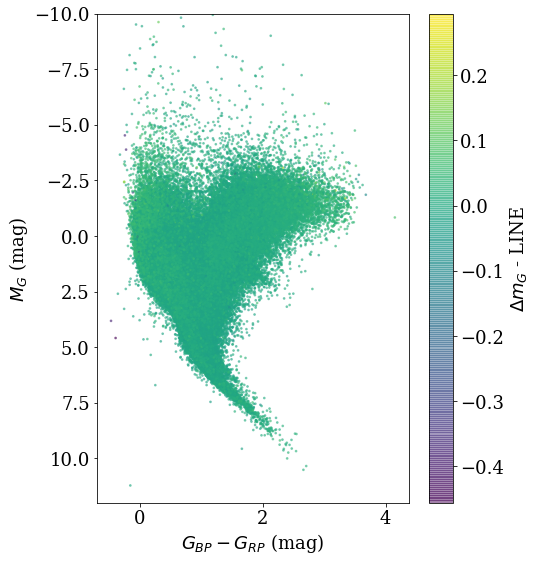

In [58]:
LINE = np.polyval(fit, df[u'bp_rp'].values[ok])

plt.figure(figsize=(7,9))
plt.scatter(df[u'bp_rp'].values[ok], 
            df[u'phot_g_mean_mag.1'].values[ok] - 5. * np.log10(1000./df[u'parallax.1'].values[ok])  + 5, 
            alpha=0.5, 
            c=DeltaG - LINE, s = 3)
plt.ylim(12,-10);
plt.xlabel('$G_{BP} - G_{RP}$ (mag)');
plt.ylabel('$M_G$ (mag)');
cb = plt.colorbar()
cb.set_label(r'$\Delta m_G$ - LINE')

Looks like our LINE fit did an OK job of characterizing the photometric offset/correction thingy

DO the outliers look like bad xmatches for some reason?
(answer from next plot: NO)

Text(0,0.5,'AngDist (arcsec)')

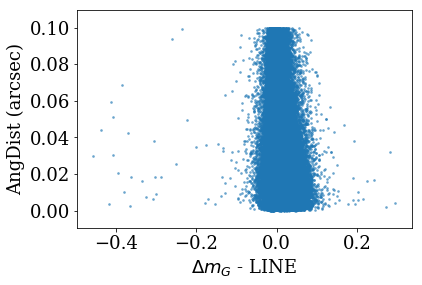

In [62]:
plt.scatter(DeltaG - LINE, df[u'angDist'].values[ok], s=3, alpha=0.5)
plt.xlabel(r'$\Delta m_G$ - LINE')
plt.ylabel('AngDist (arcsec)')

(44,)


/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10


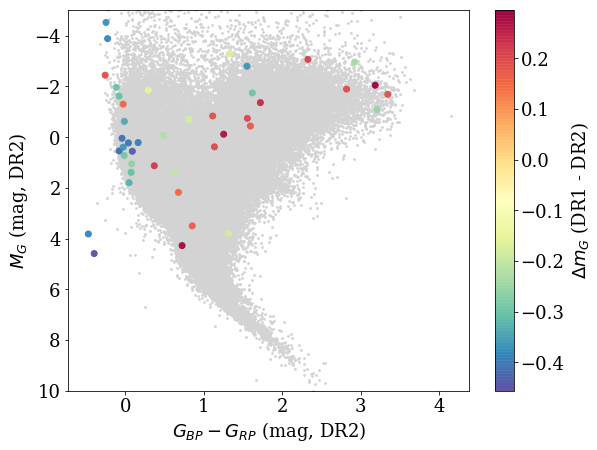

In [97]:
wow = np.where((np.abs(DeltaG - LINE) > 0.15))
print(wow[0].shape)

plt.figure(figsize=(9,7))
plt.scatter(df[u'bp_rp'].values[ok], 
            df[u'phot_g_mean_mag.1'].values[ok] - 5. * np.log10(1000./df[u'parallax.1'].values[ok])  + 5, 
            alpha=1, 
            c='LightGrey', s = 3)

plt.scatter(df[u'bp_rp'].values[ok][wow], 
            df[u'phot_g_mean_mag.1'].values[ok][wow] - 5. * np.log10(1000./df[u'parallax.1'].values[ok][wow])  + 5, 
            alpha=0.95, 
            c=(DeltaG - LINE)[wow], cmap=plt.cm.Spectral_r)
plt.ylim(10,-5);
plt.xlabel('$G_{BP} - G_{RP}$ (mag, DR2)');
plt.ylabel('$M_G$ (mag, DR2)');

cb = plt.colorbar()
cb.set_label(r'$\Delta m_G$ (DR1 - DR2)')
plt.savefig('wow_cmd.png', dpi=150, bbox_inches='tight')

Dump the variable objects to a file - to match against other things!

The bottom-left objects stand in interesting place (on the way to WD-land)

In [78]:
df_new = pd.DataFrame(data={'ra':df[u'ra_epoch2000'].values[ok][wow], 
                            'dec':df[u'dec_epoch2000'].values[ok][wow]})
df_new.to_csv('wow.csv', columns=('ra', 'dec'), index_label=False, index=False, sep=' ')

In [81]:
wow2 = np.where((np.abs(DeltaG - LINE) > 0.15) & 
                (df[u'bp_rp'].values[ok] < 0) & 
                (df[u'phot_g_mean_mag.1'].values[ok]-5*np.log10(1000./df[u'parallax.1'].values[ok])+5 > 3))

print(wow2[0].shape)

df_new = pd.DataFrame(data={'ra':df[u'ra_epoch2000'].values[ok][wow2], 
                            'dec':df[u'dec_epoch2000'].values[ok][wow2]})
df_new.to_csv('wow2.csv', columns=('ra', 'dec'), index_label=False, index=False, sep=' ')

(2,)


/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [130]:
df[u'teff_val'].values[ok][wow2]

array([8868.67, 8868.67])

Those two objects:
[obj1](http://simbad.u-strasbg.fr/simbad/sim-id?bibyear1=-20&bibyear2=%24currentYear&submit=Display&Ident=%407447949&Name=TYC+7691-3990-1) 
[obj2](http://simbad.u-strasbg.fr/simbad/sim-id?bibyear1=-50&bibyear2=%24currentYear&submit=Display&Ident=%40918883&Name=HD+265435)

Text(0,0.5,'Dec (deg)')

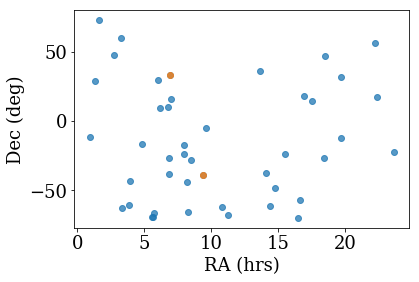

In [93]:
plt.scatter(df[u'ra_epoch2000'].values[ok][wow]/15., df[u'dec_epoch2000'].values[ok][wow], alpha=0.75)
plt.scatter(df[u'ra_epoch2000'].values[ok][wow2]/15., df[u'dec_epoch2000'].values[ok][wow2], alpha=0.75)
plt.xlabel('RA (hrs)')
plt.ylabel('Dec (deg)')

Text(0,0.5,'Dec (deg)')

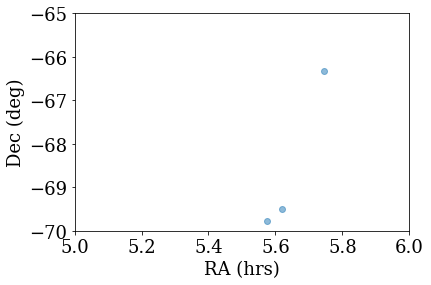

In [94]:
# objects in/near the LMC!
plt.scatter(df[u'ra_epoch2000'].values[ok][wow]/15., df[u'dec_epoch2000'].values[ok][wow], alpha=0.5)
plt.xlim(80/15,90/15)
plt.ylim(-70,-65)
plt.xlabel('RA (hrs)')
plt.ylabel('Dec (deg)')


/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log10


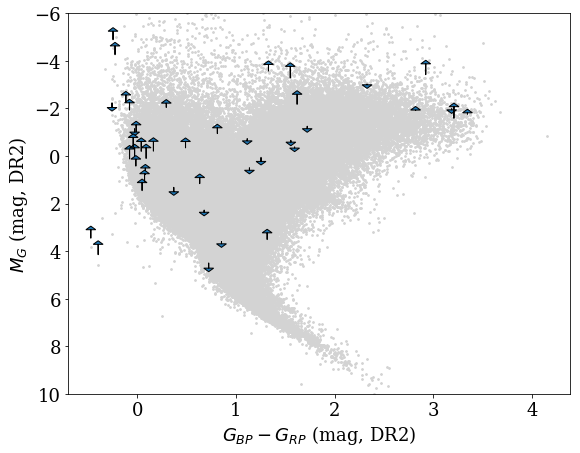

In [131]:
plt.figure(figsize=(9,7))

plt.scatter(df[u'bp_rp'].values[ok], 
            df[u'phot_g_mean_mag.1'].values[ok] - 5. * np.log10(1000./df[u'parallax.1'].values[ok])  + 5, 
            alpha=1, 
            c='LightGrey', s = 3)

# plt.scatter(df[u'bp_rp'].values[ok][wow], 
#             df[u'phot_g_mean_mag.1'].values[ok][wow] - 5. * np.log10(1000./df[u'parallax.1'].values[ok][wow])  + 5, 
#             alpha=0.95, 
#             c=(DeltaG - LINE)[wow], cmap=plt.cm.Spectral_r)

for k in range(len(wow[0])):
    plt.arrow(df[u'bp_rp'].values[ok][wow][k], 
              df[u'phot_g_mean_mag'].values[ok][wow][k]-5*np.log10(1000./df[u'parallax.1'].values[ok][wow][k])+5,
              0,DeltaG[wow][k], head_width=.1)

plt.ylim(10,-6);
plt.xlabel('$G_{BP} - G_{RP}$ (mag, DR2)');
plt.ylabel('$M_G$ (mag, DR2)');

plt.savefig('wow_cmd_arrow.png', dpi=150, bbox_inches='tight')